In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
# This is a function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
df = pd.read_csv("./Data/heart.csv",skipinitialspace = True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './Data/heart.csv'

In [ ]:
print(df.dtypes)
print("======================")
print(df.describe())

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object
              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564

Look for rows with missing values

In [ ]:
# check missing values
print(df.isnull().sum())
print("======================")
print(df.isna().sum())
print("======================")
cp = df

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
1    165
0    138
Name: output, dtype: int64
0.8363636363636363


Since count_0/count_1 > 0.8, this meet the Disparate impact 80% rule to mitigate bias result

## Removing features based on correlation

<AxesSubplot:>

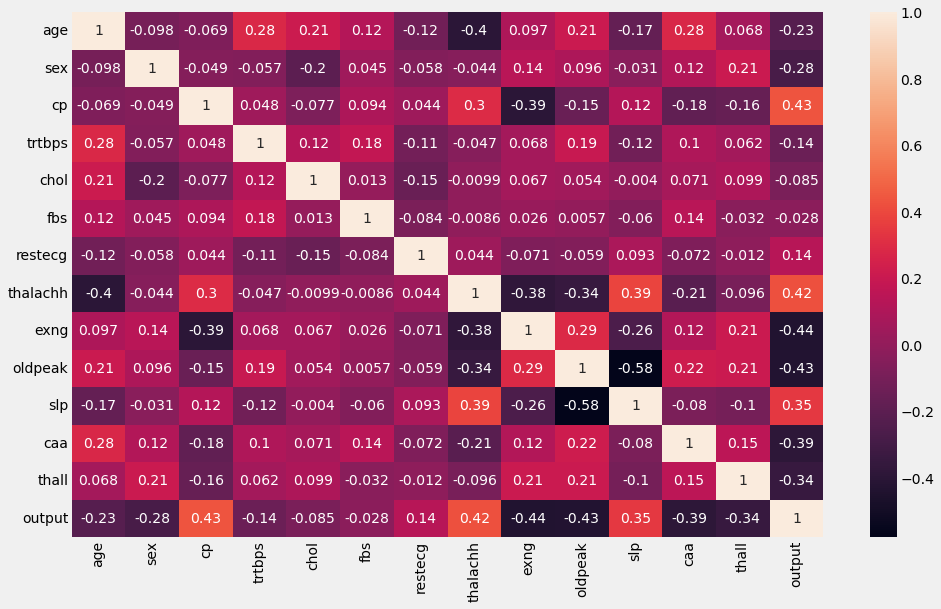

In [ ]:
plt.figure(figsize = (15,9))
corr = df.corr()
sns.heatmap(corr,annot=True)

In [ ]:
df.corr().abs()['output'].sort_values()

Removing all the col that has correlation to output lower than 0.1 or has correlation to other columns greater than 0.9 

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
print(columns)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
    if abs(corr.iloc[i,13]) <= 0.1:
        if columns[i]:
                columns[i] = False
selected_columns = df.columns[columns]
df = df[selected_columns]
df

Only 2 columns was removed: chol and fbs

## Removing outliers data using boxplot

In [ ]:
def boxplot(feature):
    plt.figure()
    sns.boxplot(df[feature])
    plt.title(feature)
    plt.show()

features = ["age","sex","cp","trtbps","restecg","thalachh","exng","oldpeak","slp","caa","thall"]

num_features = ["age","trtbps","thalachh","oldpeak","caa","thall"]
cat_features = ["sex","cp","restecg","exng","slp"]

for i in num_features:
    boxplot(i)

In [ ]:
def rm_outlier(df,feature):
    out = df
    
    min_dat = np.min(df[feature])
    max_dat = np.max(df[feature])
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    
    out = out[(out[feature] > lower_bound) & (out[feature] < upper_bound)]
    
    return out

cp = df
for i in num_features:
    cp = rm_outlier(cp,i)

df = cp
for i in num_features:
    boxplot(i)

In [ ]:
df.shape

In [ ]:
X = df.drop(columns = "output")
X.head()

In [ ]:
Y = df["output"]
Y.head()

Now split your dataset into train and test datasets, with the test set being 25% of the whole dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# prepare to scale
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
# prepare to one hot encode categorical
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# perform actions
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

set_config(display="diagram")


In [ ]:
model.fit(X_train, Y_train)

In [ ]:
model.score(X_test, Y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest =  Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=20, random_state=0))]
)

forest.fit(X_train,Y_train)

In [ ]:
from sklearn import metrics
predictions = forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, predictions))